In [1]:
# Import of used libraries
import os
import numpy as np
from PIL import Image
from pathlib import Path
from albumentations import *
import shutil
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
# Decided to rename the files to x_count, where x is id of person
def rename_images_in_folders(base_path):
    folder_path = base_path / 'train'
    
    if not folder_path.exists():
        print("Train folder not found!")
        return
    
    # Process folders 1-31
    for folder_num in range(1, 32):
        subfolder = folder_path / str(folder_num)
        
        if not subfolder.exists():
            continue
            
        image_files = sorted(subfolder.glob('*.png'))
        
        if not image_files:
            continue
            
        print(f"Folder {folder_num}: Renaming {len(image_files)} images")
        for i, img_path in enumerate(image_files, start=1):
            try:
                new_name = f"{folder_num}_{i}.png"
                new_path = subfolder / new_name
                os.rename(img_path, new_path)
                
            except Exception as e:
                print(f"Error renaming {img_path}: {str(e)}")

directory = Path('.') # Current directory or path
rename_images_in_folders(directory)

Folder 1: Renaming 6 images
Folder 2: Renaming 6 images
Folder 3: Renaming 6 images
Folder 4: Renaming 6 images
Folder 5: Renaming 6 images
Folder 6: Renaming 6 images
Folder 7: Renaming 6 images
Folder 8: Renaming 6 images
Folder 9: Renaming 6 images
Folder 10: Renaming 6 images
Folder 11: Renaming 6 images
Folder 12: Renaming 6 images
Folder 13: Renaming 6 images
Folder 14: Renaming 6 images
Folder 15: Renaming 6 images
Folder 16: Renaming 6 images
Folder 17: Renaming 6 images
Folder 18: Renaming 6 images
Folder 19: Renaming 6 images
Folder 20: Renaming 6 images
Folder 21: Renaming 6 images
Folder 22: Renaming 6 images
Folder 23: Renaming 6 images
Folder 24: Renaming 6 images
Folder 25: Renaming 6 images
Folder 26: Renaming 6 images
Folder 27: Renaming 6 images
Folder 28: Renaming 6 images
Folder 29: Renaming 6 images
Folder 30: Renaming 6 images
Folder 31: Renaming 6 images


In [3]:
# To avoid exceptions in next function we remove all wav files
def remove_non_png_files(folder_path):
    if not folder_path.exists():
        return
    
    # Process folders 1-31
    for folder_num in range(1, 32):
        subfolder = folder_path / str(folder_num)
        
        if not subfolder.exists():
            continue
            
        # Get all files
        all_files = list(subfolder.glob('*'))
        png_files = list(subfolder.glob('*.png'))
        non_png_files = [f for f in all_files if f not in png_files]
        
        if not non_png_files:
            continue
            
        print(f"Folder {folder_num}: Found {len(non_png_files)} non-PNG files")
        for file_path in non_png_files:
            try:
                os.remove(file_path)
            except Exception as e:
                print(f"Error removing {file_path}: {str(e)}")

directory = Path('./train') # Current directory or path
remove_non_png_files(directory)

Folder 1: Found 6 non-PNG files
Folder 2: Found 6 non-PNG files
Folder 3: Found 6 non-PNG files
Folder 4: Found 6 non-PNG files
Folder 5: Found 6 non-PNG files
Folder 6: Found 6 non-PNG files
Folder 7: Found 6 non-PNG files
Folder 8: Found 6 non-PNG files
Folder 9: Found 6 non-PNG files
Folder 10: Found 6 non-PNG files
Folder 11: Found 6 non-PNG files
Folder 12: Found 6 non-PNG files
Folder 13: Found 6 non-PNG files
Folder 14: Found 6 non-PNG files
Folder 15: Found 6 non-PNG files
Folder 16: Found 6 non-PNG files
Folder 17: Found 6 non-PNG files
Folder 18: Found 6 non-PNG files
Folder 19: Found 6 non-PNG files
Folder 20: Found 6 non-PNG files
Folder 21: Found 6 non-PNG files
Folder 22: Found 6 non-PNG files
Folder 23: Found 6 non-PNG files
Folder 24: Found 6 non-PNG files
Folder 25: Found 6 non-PNG files
Folder 26: Found 6 non-PNG files
Folder 27: Found 6 non-PNG files
Folder 28: Found 6 non-PNG files
Folder 29: Found 6 non-PNG files
Folder 30: Found 6 non-PNG files
Folder 31: Found 6 

In [4]:
# In this cell we divide the training data into train an validation set
# For train we perform flip of all train images to increase the number 
# of images. Dev file is used as test data and as validation we keep
# last two images of each person. So size of dev and val is same.

# Setup paths
train_folder = './train'
val_folder = './val'
os.makedirs(val_folder, exist_ok=True)

def flip_horizontal(image):
    img_array = np.array(image)
    img_array = np.fliplr(img_array)
    return Image.fromarray(img_array)

for class_dir in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_dir)
    val_class_path = os.path.join(val_folder, class_dir)
    
    if not os.path.isdir(class_path):
        continue
    
    # Create validation class folder
    os.makedirs(val_class_path, exist_ok=True)
    
    # Get all images and sort them to ensure consistent ordering
    all_images = sorted(os.listdir(class_path))
    num_images = len(all_images)
    
    # Process first N-2 images also flip training data
    for img_file in all_images[:num_images-2]:
        file_path = os.path.join(class_path, img_file)
        
        try:
            img = Image.open(file_path)
            
            # Create flipped version
            flipped_img = flip_horizontal(img)
            flipped_path = os.path.join(class_path, f"{Path(img_file).stem}_flip.jpg")
            flipped_img.save(flipped_path)
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue
    
    # Move last 2 images to validation folder without flipping
    for img_file in all_images[-2:]:
        src_path = os.path.join(class_path, img_file)
        dst_path = os.path.join(val_class_path, img_file)
        
        try:
            shutil.move(src_path, dst_path)
        except Exception as e:
            print(f"Error moving {src_path}: {str(e)}")

print("Data preparation complete!")

Data preparation complete!


In [5]:
# In this cell for each image is created 3 augmented data to increase
# the number of data. As the number of images is really small we
# decided to only slightly modify the data with gaussian noise,
# darken and brighten slightly each image. When the changes 
# were too drastic, the neural network was not able to generalize properly.

n_augments = 3 # Create 3 augmented versions per train image
folder_path = './train'

def gaussian_noise(image, mean=0, std_range=(1, 3)):
    std = np.random.uniform(*std_range)
    img_array = np.array(image).astype(np.float32)
    noise = np.random.normal(mean, std, img_array.shape)
    return Image.fromarray(np.clip(img_array + noise, 0, 255).astype(np.uint8))

def darken_img(image, darken_range=(0.95, 0.98)):
    factor = np.random.uniform(*darken_range)
    img_array = np.array(image)
    return Image.fromarray(np.clip(img_array * factor, 0, 255).astype(np.uint8))

def brighten_img(image, darken_range=(1.03, 1.08)):
    factor = np.random.uniform(*darken_range)
    img_array = np.array(image)
    return Image.fromarray(np.clip(img_array * factor, 0, 255).astype(np.uint8))

for class_dir in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_dir)
    if not os.path.isdir(class_path):
        continue
        
    for img_file in os.listdir(class_path):
        file_path = os.path.join(class_path, img_file)
        
        try:
            # Just to make sure that we use RGB due to bad experience with cv2
            img = Image.open(file_path).convert('RGB')
            
            for i in range(1, n_augments + 1): # 3 augmentations
                pil_img = img.copy()
                
                # one augmentation per variant
                if i == 1:
                    pil_img = gaussian_noise(pil_img)
                if i == 2:
                    pil_img = darken_img(pil_img)
                if i == 3:
                    pil_img = brighten_img(pil_img)
                
                pil_img.save(f"{class_path}/{Path(img_file).stem}_{i}.jpg")
                
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue

print("Augmentation complete!")

Augmentation complete!


In [11]:
# In this cell the custom cnn is defined for this classification task.

torch.set_num_threads(8)  # Match CPU core count
torch.backends.openmp.enabled = True  # Enable OpenMP

class FaceCNN(nn.Module):
    def __init__(self, num_classes=31):
        super().__init__()
        # Feature extraction
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
            
            nn.Dropout(0.3)
        )

        # Classifitaion with fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return torch.log_softmax(x, dim=1) # Output is log softmax

In [24]:
# Due to DataLoader this cell needs to be run
# It changes names from 1,2,...,9 to 01,02,...,09
# to sort correctly, because DataLoader sorts by string not numerically

def rename_folders_to_zero_padded(base_path):
    for dataset_type in ['train', 'val', 'dev']:
        dataset_path = base_path / dataset_type
        
        if not dataset_path.exists():
            print(f"{dataset_type} folder not found!")
            continue
            
        # Process folders 1-9
        for folder_num in range(1, 10):
            old_folder = dataset_path / str(folder_num)
            new_folder = dataset_path / f"0{folder_num}"
            
            if old_folder.exists():
                try:
                    os.rename(old_folder, new_folder)
                except Exception as e:
                    print(f"Error renaming {old_folder}: {str(e)}")
            else:
                print(f"Folder {dataset_type}/{folder_num} not found")

directory = Path('.')
rename_folders_to_zero_padded(directory)
print("Renaming complete!")

Renaming complete!


In [12]:
# In this cell we futhermore try to increase the number of data with
# various augmentations

# Define a series of augmentations for the training data
# These transformations will be randomly applied to each image during training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(80, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]), # ImageNet mean and std for normalization
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3))
])

# Transform for validation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]) # ImageNet mean and std for normalization
])

# Load datasets
train_dataset = datasets.ImageFolder('./train', transform=train_transform)
val_dataset = datasets.ImageFolder('./val', transform=val_transform)

# Verify data
assert len(train_dataset.classes) == 31, f"Expected 31 classes in train, got {len(train_dataset.classes)}"
assert len(val_dataset.classes) == 31, f"Expected 31 classes in val, got {len(val_dataset.classes)}"
assert train_dataset.classes == val_dataset.classes, "Class order mismatch between train and val"

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Print dataset info
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Training samples: 992
Validation samples: 62
Classes: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FaceCNN(num_classes=31).to(device)

# Create and define optimizer
optimizer = torch.optim.SGD(
    model.parameters(),  # Parameters to optimize
    lr=0.05,             # Base learning rate
    momentum=0.9,        # To accelerate convergence
    nesterov=True        # Nesterov accelerated gradient
)

# Create and define scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,                           # Max learning rate
    steps_per_epoch=len(train_loader),
    epochs=50,                            # Total number of epochs
    pct_start=0.3                         # Percentage of cycle spent increasing LR
)

# Negative Log Likelihood Loss for log softmax
criterion = nn.NLLLoss()

# Main training loop for the model.
def train(epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | '
              f'Val Acc: {val_acc:.2f}% | Best Acc: {best_acc:.2f}%')

In [14]:
# Start training
train(epochs=50)

D:\VUT\Anaconda\envs\SUR\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/50 | Loss: 3.3429 | Val Acc: 11.29% | Best Acc: 11.29%
Epoch 2/50 | Loss: 2.6568 | Val Acc: 30.65% | Best Acc: 30.65%
Epoch 3/50 | Loss: 2.0323 | Val Acc: 30.65% | Best Acc: 30.65%
Epoch 4/50 | Loss: 1.4954 | Val Acc: 30.65% | Best Acc: 30.65%
Epoch 5/50 | Loss: 1.0481 | Val Acc: 33.87% | Best Acc: 33.87%
Epoch 6/50 | Loss: 0.8427 | Val Acc: 33.87% | Best Acc: 33.87%
Epoch 7/50 | Loss: 0.6748 | Val Acc: 33.87% | Best Acc: 33.87%
Epoch 8/50 | Loss: 0.5194 | Val Acc: 38.71% | Best Acc: 38.71%
Epoch 9/50 | Loss: 0.4030 | Val Acc: 32.26% | Best Acc: 38.71%
Epoch 10/50 | Loss: 0.4011 | Val Acc: 51.61% | Best Acc: 51.61%
Epoch 11/50 | Loss: 0.3325 | Val Acc: 35.48% | Best Acc: 51.61%
Epoch 12/50 | Loss: 0.3181 | Val Acc: 48.39% | Best Acc: 51.61%
Epoch 13/50 | Loss: 0.2848 | Val Acc: 50.00% | Best Acc: 51.61%
Epoch 14/50 | Loss: 0.2323 | Val Acc: 46.77% | Best Acc: 51.61%
Epoch 15/50 | Loss: 0.2509 | Val Acc: 59.68% | Best Acc: 59.68%
Epoch 16/50 | Loss: 0.1915 | Val Acc: 58.06% | Be

In [5]:
# Load the best performing model for testing
model = FaceCNN(num_classes=31).to(device)
model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Load the saved weights from the best model checkpoint
model.eval()  # Set to evaluation mode

FaceCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [17]:
# Transformations for test data 
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('./dev', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=62, shuffle=False)

In [18]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return all_preds, all_labels, accuracy # For further analysis

In [19]:
# Additional metrics
from sklearn.metrics import confusion_matrix

# Get predictions
predictions, true_labels, test_acc = evaluate(model, test_loader)

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))

Test Accuracy: 74.19%

Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0

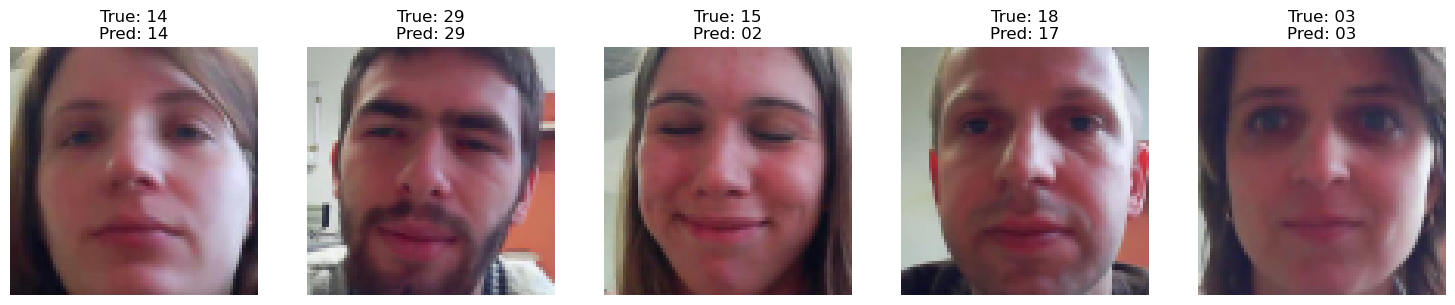

In [20]:
import matplotlib.pyplot as plt

# Visualize model predictions on random test samples
def show_test_samples(model, dataset, num_samples=5):
    indices = torch.randperm(len(dataset))[:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)
        
        img = image.squeeze().cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'True: {dataset.classes[label]}\nPred: {dataset.classes[pred.item()]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_test_samples(model, test_dataset)

In [22]:
def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image)

def generate_output_file(model, image_dir, output_file, transform):
    model.eval()
    results = []
    
    # Get all png files in directory
    image_files = sorted([f for f in os.listdir(image_dir) 
                  if os.path.isfile(os.path.join(image_dir, f)) and f.lower().endswith('.png')])
    
    with torch.no_grad():
        for img_file in image_files:
            img_path = os.path.join(image_dir, img_file)
            
            # Load and transform image
            image = load_image(img_path, transform)
            image = image.unsqueeze(0).to(device)
            
            # Get model predictions
            output = model(image)
            log_probs = torch.log_softmax(output, dim=1).cpu().numpy()[0]
            pred_class = np.argmax(log_probs) + 1  # Convert to 1-31
            
            filename = Path(img_file).stem
            line = f"{filename} {pred_class} " + " ".join(f"{prob:.6f}" for prob in log_probs)
            results.append(line)
    
    with open(output_file, 'w') as f:
        f.write("\n".join(results))

generate_output_file(
    model=model,
    image_dir='./eval',
    output_file='facial_recognition_results.txt',
    transform=test_transform
)